In [28]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout
from vit_flow import VITAttentionFlow
import io
import requests
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import maxflow

In [29]:
img = Image.open("image.jpg")

DEVICE =  "cpu"
print(f"Using {DEVICE}")

IMAGE_SIZE = 224
DISCARD_RATIO = 0.9

def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)

Using cpu


Using cache found in C:\Users\mouha/.cache\torch\hub\facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

In [30]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2

import maxflow

def compute_a_matrices(attentions, discard_ratio, head_fusion):
    '''Generates the A matrices as in the paper from the attention layers
    '''
    a_matrices = []
    
    for attention in attentions:
        # Getting type of fusion of channels
        if head_fusion == "mean":
            attention_heads_fused = attention.mean(axis=1)
        elif head_fusion == "max":
            attention_heads_fused = attention.max(axis=1)[0]
        elif head_fusion == "min":
            attention_heads_fused = attention.min(axis=1)[0]
        else:
            raise "Attention head fusion type Not supported"
        
        # Drop the lowest attentions, but
        # don't drop the class token
        flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
        _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
        indices = indices[indices != 0]
        flat[0, indices] = 0
        
        
        I = torch.eye(attention_heads_fused.size(-1))
        a = (attention_heads_fused + 1.0*I)/2
        
        a = a / a.sum(dim=-1)
        # a = a / a.sum(dim=-1, keepdim=True) -> verify which one is correct
        
        a_matrices.append(a)  
    
    return a_matrices
    
    
def compute_flow(a_matrices, input_node, output_flow, discard_ratio):
    '''Compute flow of a single input source
    '''
    n_tokens = a_matrices[0].size(-1)
    n_layers = len(a_matrices)
    
    n_nodes = n_layers * n_tokens

    n_vertices = int((1 - discard_ratio) * n_tokens**2 + 1)

    g = maxflow.Graph[float](n_nodes, n_vertices) 
    nodes = g.add_nodes(n_nodes) 

    ## Setting first nodes who will be sink

    for i in range(n_tokens):
        g.add_tedge(nodes[i], 0., output_flow)
        
    ## Setting final nodes who will be source
    source_weights = a_matrices[-1][0, :, input_node]
    for idx, node_number in enumerate(range(n_nodes - n_tokens, n_nodes)):
        g.add_tedge(nodes[node_number], source_weights[idx], 0)

    ## Setting internal nodes

    for n_layer, a_matrix in enumerate(a_matrices):
        if n_layer == len(a_matrices) - 1: break
        
        start_node = n_layer * n_tokens
        start_node_next = (n_layer + 1) * n_tokens
        
        for idx_x, node_number in enumerate(range(start_node, start_node + n_tokens)):
            weights = a_matrix[0,idx_x,:]
            
            for idx_y in range(n_tokens):
                if idx_y != 0: continue
                weight = weights[idx_y]
                
                if weight == 0: continue
                
                node_number_next = start_node_next + idx_y
                g.add_edge(nodes[node_number], nodes[node_number_next], 0., weight) # next layer points to layer before
                
    max_flow = g.maxflow()
    
    return max_flow


def compute_all_flows(a_matrices, output_flow, discard_ratio):
    '''Compute flow for all sources
    '''
    n_tokens = a_matrices[0].size(-1)
    
    mask = torch.Tensor(np.zeros(n_tokens))
    
    for n_token in range(n_tokens):
        mask[n_token] = compute_flow(a_matrices, n_token, output_flow, discard_ratio)
        
    mask = mask[1:]
    
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    
    return mask

def flow(attentions, discard_ratio, head_fusion, output_flow=2.):
    '''Generates attention flow mask in similar fashion as rollout
    '''
    
    # Getting a_matrices
    a_matrices = compute_a_matrices(attentions, discard_ratio, head_fusion)
    
    # must generate mask
    mask = compute_all_flows(a_matrices, output_flow, discard_ratio)

    return mask

class VITAttentionFlow:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean", discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return flow(self.attentions, self.discard_ratio, self.head_fusion)

Using attention_flow


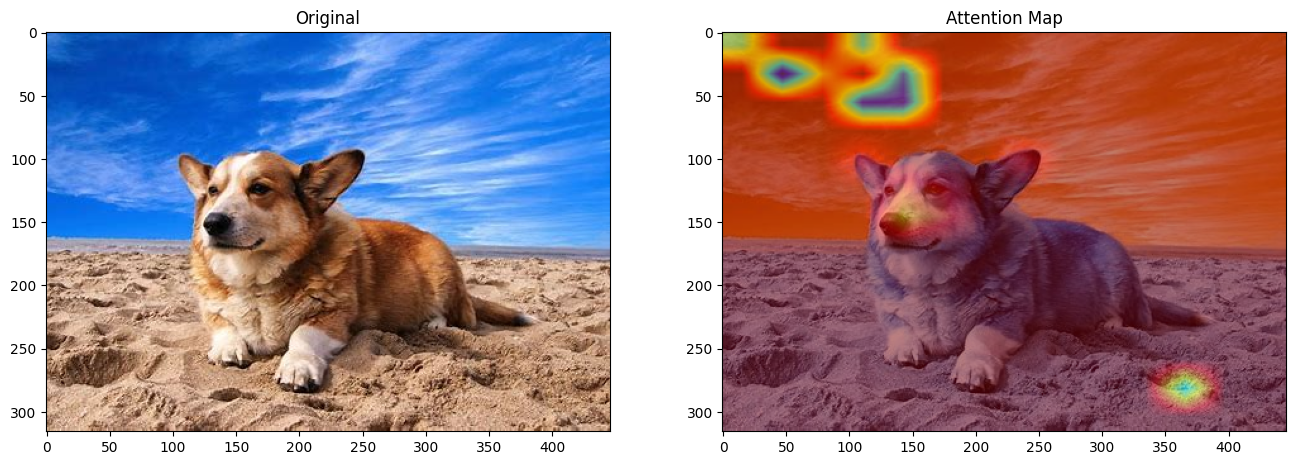

In [31]:
#@title Select the rollout strategy to be used and display results
#@markdown **Note** that for `grad_attention_rollout` passing a category index is mandatory.
rollout_strategy = "attention_flow" #@param ["attention_rollout", "grad_attention_rollout"]
category_index =  264#@param {type:"integer"}

print(f"Using {rollout_strategy}")

input_tensor  = preprocess_image("image.jpg", transform)

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")
    
elif rollout_strategy == "attention_flow":
    attention_flow = VITAttentionFlow(model, discard_ratio=DISCARD_RATIO)
    mask = attention_flow(input_tensor)
    name = "attention_flow_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

# mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)

## Attack on the model

In [32]:
import requests
import torch.nn.functional as F
output=model(input_tensor)

LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
classes = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

scores = model(input_tensor)

def print_preds(scores):
    # print the predictions with their 'probabilities' from the scores
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx

_ = print_preds(scores)

0.447 -> ['n02113023', 'Pembroke']
0.261 -> ['n02113186', 'Cardigan']
0.019 -> ['n02115641', 'dingo']
0.007 -> ['n02105412', 'kelpie']
0.004 -> ['n02106662', 'German_shepherd']


In [33]:
#performing fgsm attack
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    grad_sign = torch.sign(data_grad)

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * grad_sign

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

idx = 656 #minivan
criterion = nn.CrossEntropyLoss()
input_tensor.requires_grad = True
scores = model(input_tensor)
target = torch.tensor([idx])

#TODO: compute the loss to backpropagate
loss = criterion(scores, target)
loss.backward()

_ = print_preds(scores)

0.447 -> ['n02113023', 'Pembroke']
0.261 -> ['n02113186', 'Cardigan']
0.019 -> ['n02115641', 'dingo']
0.007 -> ['n02105412', 'kelpie']
0.004 -> ['n02106662', 'German_shepherd']


0.445 -> ['n02113023', 'Pembroke']
0.349 -> ['n02113186', 'Cardigan']
0.011 -> ['n02110806', 'basenji']
0.005 -> ['n02109525', 'Saint_Bernard']
0.003 -> ['n02105855', 'Shetland_sheepdog']


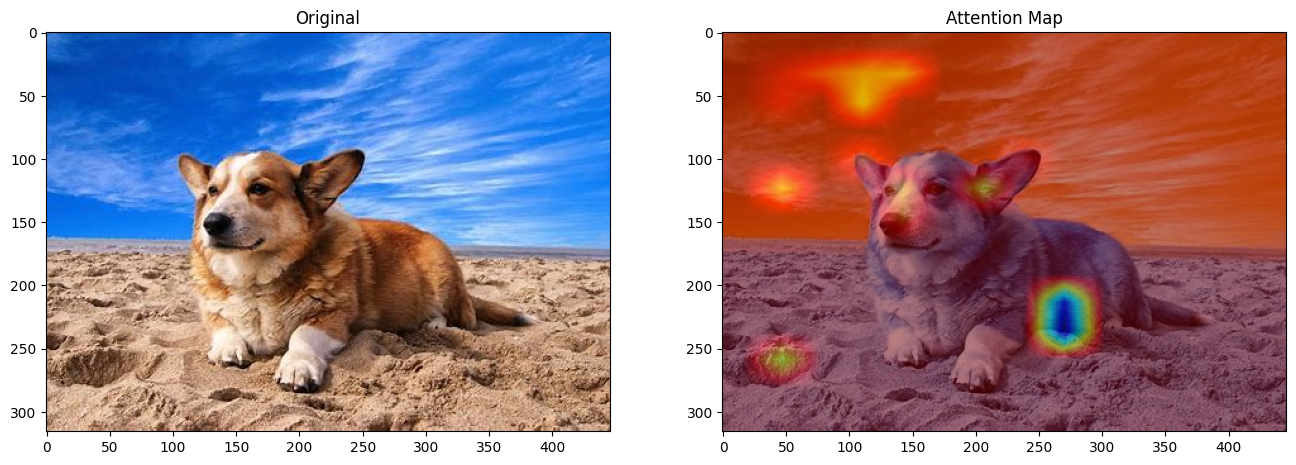

In [34]:
epsilon = 0.05
x_att=fgsm_attack(input_tensor, epsilon, input_tensor.grad.data)
scores = model(x_att)
_ = print_preds(scores)

#performing fgsm attack on the
input_tensor  = x_att

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")
    
elif rollout_strategy == "attention_flow":
    attention_flow = VITAttentionFlow(model, discard_ratio=DISCARD_RATIO)
    mask = attention_flow(input_tensor)
    name = "attention_flow_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

# mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)
